In [205]:
# Gute Fragestellung für datascience Projekt (Sportify)
# Gibt es einen Zusammenhang zwischen eigenen Musikgeschmack und der Geschmack der anderen?

# Importieren der benötigten Bibliotheken
import sys
import os as os
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import spotipy
import pandas as pd
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm_notebook

# Variablen und Funktionsdeklarationen

Um mit spotipy auf die Daten zugreiffen zu können, müssen `CLIENT_ID` und `CLIENT_SECRET` zwingendermassen gesetzt sein. Die Variablen `USERSANGEETHS` und `USERSTIAFEN` notwendig da wir mit der Spotipy methode `user_playlist` arbeiten.

In [206]:
CLIENT_ID = "082b3dd7a97642d49b60a647673caa75"
CLIENT_SECRET = "276e4715f8a14a34a7622c0105a8588c"
USERSANGEETHS = "qme120m1x3bg2wrtw3haiiyrb"
USERSTIAFEN = "stiafen"

client_credentials_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) #spotify object to access API

In [207]:
# get all playlists of a user
def get_playlists(user):
    playlists = sp.user_playlists(user)
    playlist_ids = []
    while playlists:
        for i, playlist in enumerate(playlists['items']):
            playlist_ids.append(playlist['id'])
        if playlists['next']:
            playlists = sp.next(playlists)
        else:
            playlists = None
    return playlist_ids

In [208]:
playlistsSangeeths = get_playlists(USERSANGEETHS)
playlistsTiafen = get_playlists(USERSTIAFEN)

# get the name of the playlists, will later be used to print all available playlists for a user
def get_playlist_name(user, playlist_id):
    playlist = sp.user_playlist(user, playlist_id)
    return playlist['name'], playlist['id']


In [209]:
#Funktion welche mittels user und playlist ID alle Tracks für eine Playlist ausgibt
def get_playlist_tracks(user, playlist_id):
    results = sp.user_playlist_tracks(user, playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    df = pd.DataFrame(tracks)
    df = df['track']
    df = df.apply(pd.Series)
    return df


In [210]:
#Funktion welche mittels user und playlist ID alle Tracks für eine Playlist ausgibt
def get_playlist_tracks_artists(user, playlist_id):
    results = sp.user_playlist_tracks(user, playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

In [211]:
def get_audio_features(user, tracklist):
    #Dateinamen festlegen, falls vorhanden werden diese Daten ausgewertet statt Abfragen per API zu machen
    audiofeaturesfilename = user+"_audiofeatures.csv"

    if not os.path.isfile(audiofeaturesfilename):
        genres = []
        popularity = []
        features = []

        #Extract Audio Features
        for uri in tracklist['uri']:

            features = features+sp.audio_features(uri)


        #for artist in tracksStiafen['artists']:
        #    dictionary = artist[0]
        #    artistinfo = sp.artist(dictionary['id'])
        #    artistpopularity = artistinfo['popularity']
        #    artistgenres = artistinfo['genres']
        #    popularity.append(artistpopularity)
        #    genres.append(artistgenres)

        #Dataframe generieren
        audioFeatures = pd.DataFrame(features)
        #audioFeatures['genre'] = genres
        #audioFeatures['popularity'] = popularity
        #tracklist['artistgenre'] = genres
        #Daten exportieren

        audioFeatures.to_csv(audiofeaturesfilename)
        return audioFeatures

    else:
        audioFeatures = pd.read_csv(audiofeaturesfilename)
        return audioFeatures

Um nun die ID der playlist zu erhalten, in welcher wir unsere Lieblingssongs gespeichert haben nutzen wir die zuvor definierte Funktion `get_playlist_name` welche über das Resultat der Funktion `get_playlists` für den jeweiligen Benutzer läuft.
Um die Übersicht zu behalten haben wir unsere Playlists *Fav Songs "NAME"* genannt

In [212]:
for playlist in playlistsSangeeths:
    print(get_playlist_name(USERSANGEETHS, playlist))

for playlist in playlistsTiafen:
    print(get_playlist_name(USERSTIAFEN, playlist))

('Testo pur🏋🏽', '7o70luarSZS5DHoODMH51U')
('Fav Songs Sangeeths', '2E7GAf1h3F19ezc18w1NpZ')
('Tamil Vibes', '64Lq6W07GIOs087K88iOzT')
('Arabic  Vibes', '1Rr83zHLDULxQDbC9taydm')
('Albanien Vibes', '6jyy1HUool6rj0xWLVsAPC')
('UK DRILL ', '5ycwKESGY1Z71ftYWmTVJs')
('Baba Vibes', '67a5HCEjwm4aXvjPVoxoAX')
('Fav Songs Stiafen', '0ekbyk9EKkCf4MBjrQoM2D')
('Favorite Songs', '4DeCJm3aeeb0TTdthf8MGY')
('Caterpillar (feat. Eminem & King Green)', '1JKSl9B6hJNCGFs9FdOq8I')
('Meine Playlist Nr.\xa034', '3uBDJVShkGJKFxPNnjC7IL')
('Dein Mixtape\xa06 - ZUSAMMENGESTELLT FÜR STIAFEN:21.06.19', '48I13UCIzloZpyRE23zwIa')
('Mixtape 3', '2jnqcj5CxaBLHjzVafdmce')
('Oldschool', '4RjDNPzba04zlAan0a4bTE')


# Datensatz laden, filtern und verstehen
Nun da wir die Playlist ID haben können wir die Tracks aus unseren Fav Songs Playlists auslesen und mittels unserer Funktion die audio Features extrahieren.
Zuerst schreiben wir also alle Tracks mit deren Informationen in eine Liste `tracksSangeeths` und `tracksStiafen`

In [213]:
#Variablen für Playlists Sangeeths und Stiafen
favoritplaylistSangeeths = "2E7GAf1h3F19ezc18w1NpZ"
favoritplaylistStiafen = "0ekbyk9EKkCf4MBjrQoM2D"

# Für Beide User wird eine Liste mit den Trackinfos erstellt
tracksSangeeths = get_playlist_tracks(USERSANGEETHS, favoritplaylistSangeeths)
tracksStiafen = get_playlist_tracks(USERSTIAFEN, favoritplaylistStiafen)

Nun holen wir die Audiofeatures aus allen Tracks und führen diese in einem Dataframe `audioFeaturesTotal`

In [214]:
audioFeaturesStiafen = get_audio_features("Stiafen", tracksStiafen)
audioFeaturesSangeeths = get_audio_features("Sangeeths", tracksSangeeths)
#Um über das Gesamtbild der Daten eine aussage machen zu können nehmen wir beide Dataframes in eines
audioFeaturesTotal = audioFeaturesStiafen.append(audioFeaturesSangeeths)

C:\Users\Startklar\AppData\Local\Temp\ipykernel_12184\881909890.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  audioFeaturesTotal = audioFeaturesStiafen.append(audioFeaturesSangeeths)


,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0,0.0614,0.05800,2,-20.976,1,0.0418,0.9180,0.91500,0.1490,0.0329,58.193,audio_features,3ddAtoSripaeASJeovlIsg,spotify:track:3ddAtoSripaeASJeovlIsg,https://api.spotify.com/v1/tracks/3ddAtoSripae...,https://api.spotify.com/v1/audio-analysis/3ddA...,1463704,4
1,1,0.2990,0.00626,9,-30.923,1,0.0478,0.9940,0.90100,0.0823,0.0634,69.043,audio_features,1Oo7XEqkrwifJn17aA0ocF,spotify:track:1Oo7XEqkrwifJn17aA0ocF,https://api.spotify.com/v1/tracks/1Oo7XEqkrwif...,https://api.spotify.com/v1/audio-analysis/1Oo7...,378733,4
2,2,0.0877,0.07630,9,-23.986,1,0.0429,0.6450,0.89700,0.3530,0.0509,78.535,audio_features,3o9br9LskOEbwc5irxfHqR,spotify:track:3o9br9LskOEbwc5irxfHqR,https://api.spotify.com/v1/tracks/3o9br9LskOEb...,https://api.spotify.com/v1/audio-analysis/3o9b...,295219,4
3,3,0.1760,0.05340,10,-27.626,1,0.0406,0.9700,0.91500,0.2900,0.0332,71.673,audio_features,5TtmI9sfXw4VXco0PE21mV,spotify:track:5TtmI9sfXw4VXco0PE21mV,https://api.spotify.com/v1/tracks/5TtmI9sfXw4V...,https://api.spotify.com/v1/audio-analysis/5Ttm...,132120,5
4,4,0.4280,0.00300,0,-31.005,1,0.0709,0.9950,0.92400,0.0889,0.0934,69.108,audio_features,6aD8MeXrjHNz7YgrTLHhyA,spotify:track:6aD8MeXrjHNz7YgrTLHhyA,https://api.spotify.com/v1/tracks/6aD8MeXrjHNz...,https://api.spotify.com/v1/audio-analysis/6aD8...,407947,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,794,0.5940,0.80300,6,-6.269,1,0.2650,0.0449,0.00000,0.2370,0.2580,84.781,audio_features,18RbeUUUMsFwXAwIJH89FZ,spotify:track:18RbeUUUMsFwXAwIJH89FZ,https://api.spotify.com/v1/tracks/18RbeUUUMsFw...,https://api.spotify.com/v1/audio-analysis/18Rb...,145322,4
795,795,0.6020,0.52600,11,-8.748,1,0.4010,0.1470,0.00000,0.0874,0.5120,72.661,audio_features,7BkH7723qQS16zB4MFVxPL,spotify:track:7BkH7723qQS16zB4MFVxPL,https://api.spotify.com/v1/tracks/7BkH7723qQS1...,https://api.spotify.com/v1/audio-analysis/7BkH...,134480,3
796,796,0.7350,0.61500,4,-6.463,0,0.0670,0.0281,0.00444,0.0517,0.4060,97.912,audio_features,179RlsezyrYKDp9vsyTe5L,spotify:track:179RlsezyrYKDp9vsyTe5L,https://api.spotify.com/v1/tracks/179RlsezyrYK...,https://api.spotify.com/v1/audio-analysis/179R...,113878,4
797,797,0.5690,0.54600,9,-8.306,0,0.4510,0.3380,0.00000,0.0507,0.6340,96.796,audio_features,7cOsxqgK2oqjEX709MT4hB,spotify:track:7cOsxqgK2oqjEX709MT4hB,https://api.spotify.com/v1/tracks/7cOsxqgK2oqj...,https://api.spotify.com/v1/audio-analysis/7cOs...,196000,4


Nun verschaffen wir uns einen überblick wie die Daten aussehen

In [215]:
audioFeaturesTotal.describe()

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1.450000e+03,1450.000000
mean,365.776552,0.526701,0.405721,5.343448,-15.138781,0.594483,0.139410,0.557975,0.362771,0.149622,0.355279,111.092376,2.769033e+05,3.857241
std,215.772673,0.242342,0.319077,3.564738,10.375151,0.491161,0.137888,0.403521,0.429629,0.117776,0.246132,31.742395,2.296056e+05,0.539310
min,0.000000,0.060600,0.000962,0.000000,-44.761000,0.000000,0.028700,0.000145,0.000000,0.013700,0.031900,45.194000,3.286700e+04,1.000000
25%,181.000000,0.309250,0.055800,2.000000,-24.286750,0.000000,0.041900,0.142250,0.000000,0.087800,0.124000,87.070250,1.635235e+05,4.000000
50%,362.000000,0.545500,0.488000,5.000000,-9.350000,1.000000,0.057600,0.524500,0.001945,0.111000,0.335500,105.015000,2.076850e+05,4.000000
75%,543.000000,0.752750,0.700000,9.000000,-6.135000,1.000000,0.230750,0.987000,0.895000,0.155000,0.547500,134.986500,3.092068e+05,4.000000
max,798.000000,0.962000,0.986000,11.000000,0.366000,1.000000,0.926000,0.996000,0.974000,0.980000,0.967000,207.152000,4.581483e+06,5.000000


In [216]:
audioFeaturesTotal.head()

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0,0.0614,0.05800,2,-20.976,1,0.0418,0.918,0.915,0.1490,0.0329,58.193,audio_features,3ddAtoSripaeASJeovlIsg,spotify:track:3ddAtoSripaeASJeovlIsg,https://api.spotify.com/v1/tracks/3ddAtoSripae...,https://api.spotify.com/v1/audio-analysis/3ddA...,1463704,4
1,1,0.2990,0.00626,9,-30.923,1,0.0478,0.994,0.901,0.0823,0.0634,69.043,audio_features,1Oo7XEqkrwifJn17aA0ocF,spotify:track:1Oo7XEqkrwifJn17aA0ocF,https://api.spotify.com/v1/tracks/1Oo7XEqkrwif...,https://api.spotify.com/v1/audio-analysis/1Oo7...,378733,4
2,2,0.0877,0.07630,9,-23.986,1,0.0429,0.645,0.897,0.3530,0.0509,78.535,audio_features,3o9br9LskOEbwc5irxfHqR,spotify:track:3o9br9LskOEbwc5irxfHqR,https://api.spotify.com/v1/tracks/3o9br9LskOEb...,https://api.spotify.com/v1/audio-analysis/3o9b...,295219,4
3,3,0.1760,0.05340,10,-27.626,1,0.0406,0.970,0.915,0.2900,0.0332,71.673,audio_features,5TtmI9sfXw4VXco0PE21mV,spotify:track:5TtmI9sfXw4VXco0PE21mV,https://api.spotify.com/v1/tracks/5TtmI9sfXw4V...,https://api.spotify.com/v1/audio-analysis/5Ttm...,132120,5
4,4,0.4280,0.00300,0,-31.005,1,0.0709,0.995,0.924,0.0889,0.0934,69.108,audio_features,6aD8MeXrjHNz7YgrTLHhyA,spotify:track:6aD8MeXrjHNz7YgrTLHhyA,https://api.spotify.com/v1/tracks/6aD8MeXrjHNz...,https://api.spotify.com/v1/audio-analysis/6aD8...,407947,3


In [217]:
audioFeaturesTotal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        1450 non-null   int64  
 1   danceability      1450 non-null   float64
 2   energy            1450 non-null   float64
 3   key               1450 non-null   int64  
 4   loudness          1450 non-null   float64
 5   mode              1450 non-null   int64  
 6   speechiness       1450 non-null   float64
 7   acousticness      1450 non-null   float64
 8   instrumentalness  1450 non-null   float64
 9   liveness          1450 non-null   float64
 10  valence           1450 non-null   float64
 11  tempo             1450 non-null   float64
 12  type              1450 non-null   object 
 13  id                1450 non-null   object 
 14  uri               1450 non-null   object 
 15  track_href        1450 non-null   object 
 16  analysis_url      1450 non-null   object 
 

Es muss bemerkt werden das die Spalte *Unnamed: 0* ein Nebenprodukt des CSV imports ist. Diese Spalte wird daher gefiltert, ebenso wie die für unsere weiteren Aufgaben unrelevanten Spalten
  *type*, *id*, *analysis_url*, *uri*, *track_href*, *duration_ms*, *time_signature*

In [218]:
if "Unnamed: 0" in audioFeaturesTotal.columns:
    audioFeaturesTotal.drop("Unnamed: 0", axis=1, inplace=True)

audioFeaturesTotal.drop("track_href", axis=1, inplace=True)
audioFeaturesTotal.drop("analysis_url", axis=1, inplace=True)
audioFeaturesTotal.drop("id", axis=1, inplace=True)
audioFeaturesTotal.drop("uri", axis=1, inplace=True)
audioFeaturesTotal.drop("type", axis=1, inplace=True)
audioFeaturesTotal.drop("key", axis=1, inplace=True)
audioFeaturesTotal.drop("duration_ms", axis=1, inplace=True)
audioFeaturesTotal.drop("time_signature", axis=1, inplace=True)

# Data Quality Assesment
Im Data Quality Assesment schauen wir uns noch Nullwerte und die Min, Max Werte der Spalten an

In [219]:
audioFeaturesTotal.isnull().sum()

danceability        0
energy              0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
dtype: int64

Um die Min Max Werte der Spalten zu erhalten nutzen wir nochmals die describe Methode. Die Werte sehen realistisch aus

In [220]:
audioFeaturesTotal.describe()

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000
mean,0.526701,0.405721,-15.138781,0.594483,0.139410,0.557975,0.362771,0.149622,0.355279,111.092376
std,0.242342,0.319077,10.375151,0.491161,0.137888,0.403521,0.429629,0.117776,0.246132,31.742395
min,0.060600,0.000962,-44.761000,0.000000,0.028700,0.000145,0.000000,0.013700,0.031900,45.194000
25%,0.309250,0.055800,-24.286750,0.000000,0.041900,0.142250,0.000000,0.087800,0.124000,87.070250
50%,0.545500,0.488000,-9.350000,1.000000,0.057600,0.524500,0.001945,0.111000,0.335500,105.015000
75%,0.752750,0.700000,-6.135000,1.000000,0.230750,0.987000,0.895000,0.155000,0.547500,134.986500
max,0.962000,0.986000,0.366000,1.000000,0.926000,0.996000,0.974000,0.980000,0.967000,207.152000


# Data Preprocessing
Um die Datenstandardisierung durchzuführen nutzen wir den Standard Scaler

In [237]:
X = audioFeaturesTotal

scaler =  StandardScaler()
scaledAudioFeaturesTotal = scaler.fit_transform(X)
scaledAudioFeaturesTotal

array([[-1.92068144, -1.090145  , -0.56280941, ..., -1.31023387,
        -1.6670962 ,  1.09254107],
       [-0.93990997, -1.25235595, -1.52187323, ..., -1.18627389,
        -1.32516412,  1.09254107],
       [-1.81211962, -1.03277236, -0.85302576, ..., -1.23707716,
        -1.0260287 ,  1.09254107],
       ...,
       [ 0.85982218,  0.65611512,  0.83649623, ...,  0.20614215,
        -0.41537266, -0.9152974 ],
       [ 0.17460306,  0.43979206,  0.65879898, ...,  1.13279381,
        -0.45054282, -0.9152974 ],
       [ 1.16940913,  0.42411647,  0.72050611, ...,  1.17343643,
         0.9060609 , -0.9152974 ]])

# Datenvisualisierungen
Da wir mit K-Means arbeiten wollen, suchen wir bei der Visualisierung mittels Scatterplots nach möglichen Clustern.

In [224]:
#Beginn Visualisierungen
#Dataframe für Visualisierung (ohne Standartisierte Daten)
allAudioFeatures = audioFeaturesTotal

<AxesSubplot:xlabel='danceability', ylabel='count'>

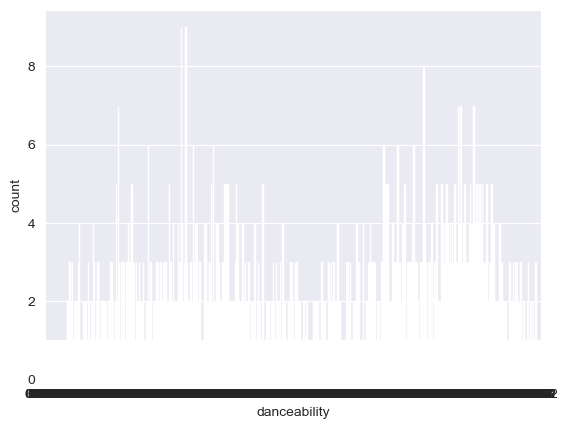

In [239]:
sns.countplot(x = allAudioFeatures["danceability"])

Die Untenstehende Grafik hat unserer Meinung nach die deutlichste Clusterbildung aufgezeigt, weswegen wir uns für diese Werte

<AxesSubplot:xlabel='energy', ylabel='danceability'>

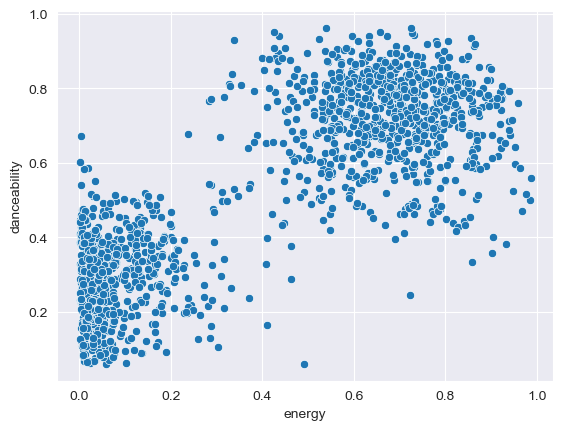

In [226]:
sns.scatterplot(data=allAudioFeatures, x="energy", y="danceability")

<AxesSubplot:xlabel='energy', ylabel='loudness'>

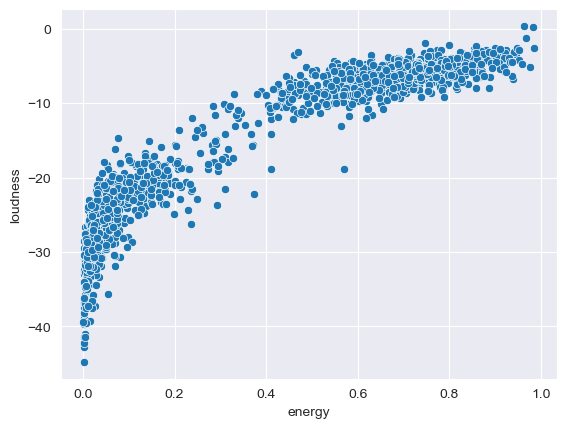

In [228]:
sns.scatterplot(data=allAudioFeatures, x="energy", y="loudness")

<AxesSubplot:xlabel='acousticness', ylabel='instrumentalness'>

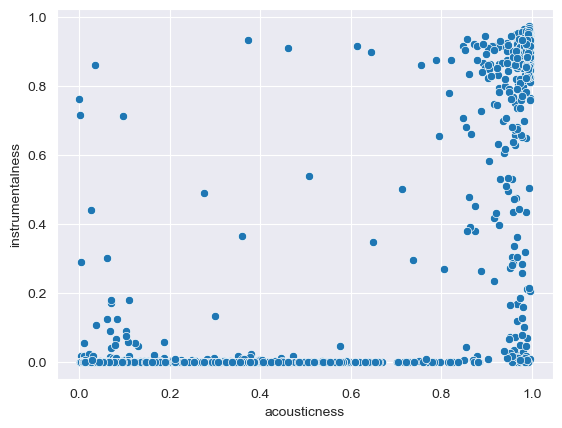

In [229]:
sns.scatterplot(data=allAudioFeatures, x="acousticness", y="instrumentalness")

C:\Users\Startklar\AppData\Local\Temp\ipykernel_12184\2014212249.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(K):


  0%|          | 0/9 [00:00<?, ?it/s]

C:\Users\Startklar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


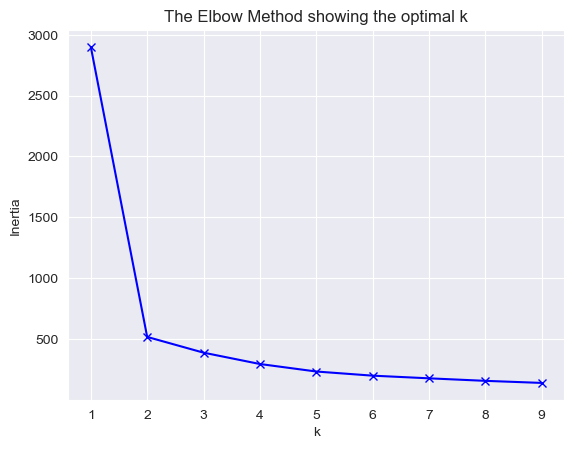

In [230]:



X = allAudioFeatures[['energy','danceability']]

scaler =  StandardScaler()
X_scaled = scaler.fit_transform(X)
inertias = []
K = range(1,10)
for k in tqdm_notebook(K):
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_scaled)
    inertias.append(kmeanModel.inertia_)
    
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')

plt.plot(K, inertias, 'bx-')

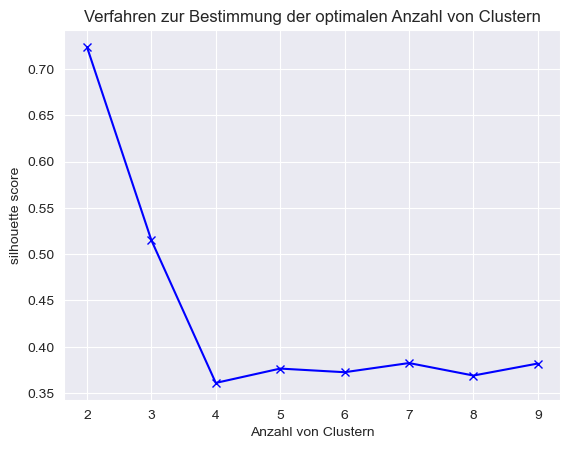

In [231]:

# Merkmale aus der Tabelle auswählen
X = allAudioFeatures[['energy','danceability']].values

# Liste der Anzahl von Clustern erstellen
k_values = range(2, 10)

# Leere Liste für silhouette scores erstellen
scores = []

# Schleife über die Anzahl von Clustern
for k in k_values:
  # K-Means-Modell erstellen
  model = KMeans(n_clusters=k)
  # Modell an die Daten anpassen
  model.fit(X)
  # silhouette score für das Modell berechnen
  score = silhouette_score(X, model.labels_)
  scores.append(score)

# Plot der silhouette scores gegenüber der Anzahl von Clustern erstellen
plt.plot(k_values, scores, 'bx-')
plt.xlabel('Anzahl von Clustern')
plt.ylabel('silhouette score')
plt.title('Verfahren zur Bestimmung der optimalen Anzahl von Clustern')
plt.show()

<AxesSubplot:xlabel='energy', ylabel='danceability'>

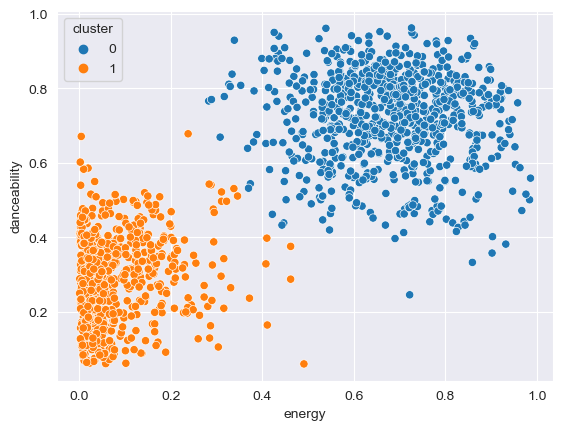

In [232]:


# take the highest value of the silhouette score
kmeans = KMeans(n_clusters=2)
kmeans.fit(allAudioFeatures[['energy', 'danceability']])
allAudioFeatures['cluster'] = kmeans.labels_

sns.scatterplot(data=allAudioFeatures, x="energy", y="danceability", hue="cluster")